<center><h2>Transfer learning U-net</h2></center>

Adaptation from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

https://heartbeat.fritz.ai/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab

In [1]:
import segmentation_models_pytorch as smp

In [2]:
category_dict = {0: "other_stuff", 1: "road", 2: "sidewalk", 3: "greens", 4: "Biker",
                5: "Pedestrian", 6: "Skater", 7: "Cart", 8: "Car", 9: "Bus"}

category_clr = {0: [0, 0, 0], 1: [128, 64, 128], 2: [130, 76, 0], 3: [107, 142, 35], 4: [28, 42, 168],
                5: [255, 22, 96], 6: [102, 51, 0], 7: [9, 143, 150], 8: [119, 11, 32], 9: [112, 150, 146]}
num_classes = len(category_dict)

In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = '/media/hdd/stanford_campus_dataset/data/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'Train/Image')
y_train_dir = os.path.join(DATA_DIR, 'Train/Mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val/Image')
y_valid_dir = os.path.join(DATA_DIR, 'Val/Mask')

x_test_dir = os.path.join(DATA_DIR, 'Test/Image')
y_test_dir = os.path.join(DATA_DIR, 'Test/Mask')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """Stanford Drone Dataset with customization. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        
        self.classes_all = ["other_stuff", "road", "sidewalk", "greens", "Biker",
                "Pedestrian", "Skater", "Cart", "Car", "Bus"]
        self.classes = classes
        if self.classes is None:
            self.classes = self.classes_all
        print(self.classes)
            
        self.category_clr = {0: [0, 0, 0], 1: [128, 64, 128], 2: [130, 76, 0], 3: [107, 142, 35], 4: [28, 42, 168],
                5: [255, 22, 96], 6: [102, 51, 0], 7: [9, 143, 150], 8: [119, 11, 32], 9: [112, 150, 146]}
        
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:-4] + ".png") for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_clrs = [self.category_clr[self.classes_all.index(cls)] for cls in self.classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])
        
        # extract certain classes from mask
#         masks = [(mask == v) for v in self.class_clrs]
        masks = [np.all(mask == clr, axis=-1) for clr in self.class_clrs]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

['sidewalk']


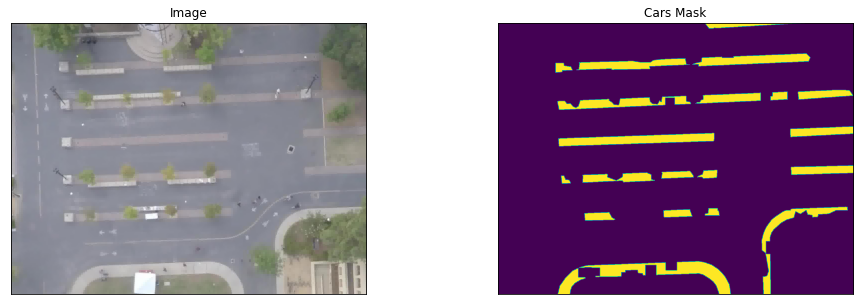

In [9]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['sidewalk'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

Since our dataset is very small we will apply a large number of different augmentations:

- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

In [10]:
import albumentations as albu

In [17]:
def get_training_augmentation():
    train_transform = [

        albu.augmentations.geometric.resize.Resize(1088, 1088, interpolation=1, always_apply=True, p=1),
        
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(1088, 1088)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')



def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

['road']


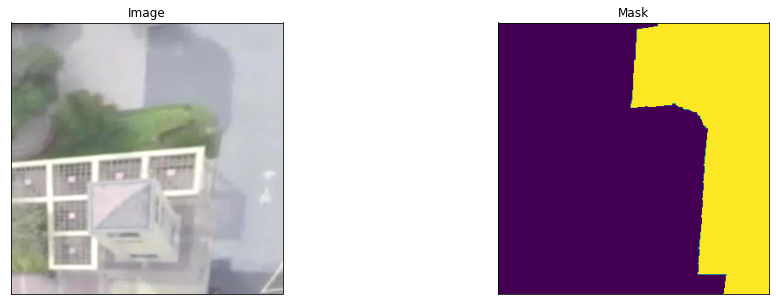

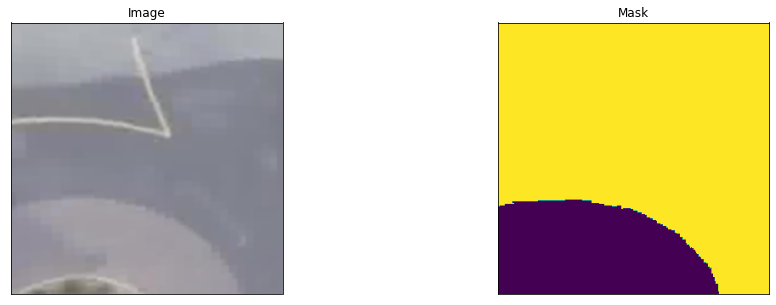

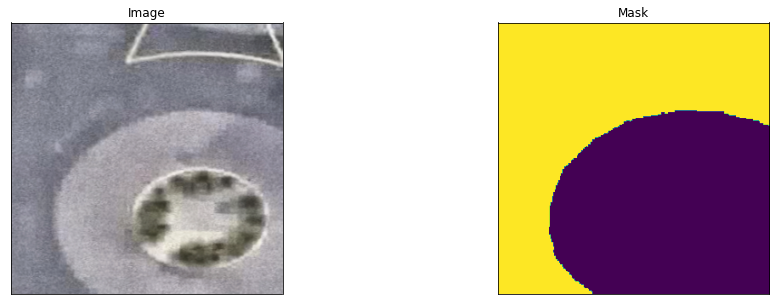

In [18]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
model = smp.Unet('resnet34', classes=num_classes, activation='softmax')